# Import

In [1]:
import openrouteservice
from openrouteservice import convert
import folium
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Data

In [2]:
traffic_data=(r'..\data\traffic_data.xlsx')
satelit_data=(r'..\data\AgERA5_4params_graz.csv')
temporal_data=(r'..\data\new_5sta(DNOWS)_3com(NO2,PM10K,O3)_year2010_TemporalDummies_Ox_holidays_meteo.csv')

In [3]:
df_satelit= pd.read_csv(satelit_data,index_col = 0)
df_temporal =pd.read_csv(temporal_data,index_col = 0)

In [4]:
df_satelit.index = pd.to_datetime(df_satelit.index)

In [5]:
df_temporal.index = pd.to_datetime(df_temporal.index)

In [6]:
df_ulice = pd.read_excel(traffic_data, engine='openpyxl', sheet_name='street', index_col=0)
df_ulice_podaci = pd.read_excel(traffic_data, engine='openpyxl', sheet_name='traffic_data', index_col=0)

In [7]:
df_ulice_podaci=df_ulice_podaci['2018-01-01':'2020-03-15']
df_satelit=df_satelit['2018-01-01':'2020-03-15']
df_temporal=df_temporal['2018-01-01':'2020-03-15']

In [8]:
df_ulice = df_ulice.drop(['Unnamed: 1','Street','Abschnitt',],axis = 1)

In [9]:
df_ulice = df_ulice.drop(['Nord','Sud','West','Ost','DonBosco'],axis = 0)

In [10]:
df_ulice_podaci = df_ulice_podaci.fillna(df_ulice_podaci.mean())

In [11]:
df_temporal_new = df_temporal[['year', 'dayofyear',
       'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
       'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov',
       'month_Oct', 'month_Sep', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'season_fall', 'season_spring',
       'season_summer', 'season_winter','holiday',
       'holiday_school']]
df_satelit_new = df_satelit[['Cloud_Cover_Mean','Wind_Speed_10m_Mean']]

# key sa stranice kad se log in https://openrouteservice.org/dev/#/home

In [12]:
client = openrouteservice.Client(key='5b3ce3597851110001cf624866bbf1eb192e45148c3b15f3088db4c2')

In [13]:
df_ulice

,Directions,Longitude,Latitude,Reference_station,Distance to ref,AVG traffic,num_of_roads,semafor,Unnamed: 12
Code,,,,,,,,,
Ost_8010_208,SouthNorth,15.443536,47.077866,Ost,2689.680221,963.134172,18.0,1.0,NaN
DonBosco_8020_110,SouthNorth,15.418848,47.058659,DonBosco,381.001390,985.662456,13.0,1.0,bus stop near by
DonBosco_8020_119,EastWest,15.431343,47.066870,DonBosco,1682.330202,455.922269,7.0,1.0,NaN
DonBosco_8020_122,EastWest,15.431727,47.057316,DonBosco,1169.351420,1214.595238,15.0,1.0,middle of city
DonBosco_8053_111,SouthNorth,15.414219,47.043459,DonBosco,1363.162404,914.792017,13.0,1.0,NaN
Nord_8010_205,EastWest,15.426301,47.087794,Nord,1120.294237,645.190077,4.0,0.0,tunnel
Ost_8010_209,EastWest,15.457930,47.076679,Ost,2017.995362,602.967855,12.0,1.0,dosta drveca mozda dio NO2 adsorbiraju
Ost_8010_213,East,15.444325,47.065714,Ost,1828.992486,595.693978,5.0,1.0,NaN
Ost_8010_214,SouthNorth,15.448640,47.054039,Ost,1497.288645,696.783844,9.0,1.0,NaN


# Maknut lokaciju za koju mjerimo udaljenosti DonBosco_8020_119

In [14]:
df_ulice=df_ulice.drop('DonBosco_8020_119',axis=0)

# udaljenosti 

In [56]:
m = folium.Map(location=[47.0707, 15.4395],zoom_start=10, control_scale=True,tiles="cartodbpositron")
dictionary = {'postaja':[],'udaljenost_u_km':[]}
d={}
for longitude,latitude,postaja, in zip(df_ulice.Longitude,df_ulice.Latitude,df_ulice.index):
    coords = ((longitude,latitude),(15.431343,47.066870))  
    res = client.directions(coords)
    geometry = client.directions(coords)['routes'][0]['geometry']
    decoded = convert.decode_polyline(geometry)
    distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['distance']/1000,1))+" Km </strong>" +"</h4></b>"
    duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(round(res['routes'][0]['summary']['duration']/60,1))+" Mins. </strong>" +"</h4></b>"
    udaljenost = round(res['routes'][0]['summary']['distance']/1000,1)
    dictionary['postaja'].append(postaja)
    dictionary['udaljenost_u_km'].append(udaljenost)
    d.update({postaja:udaljenost})
    folium.GeoJson(decoded).add_child(folium.Popup(distance_txt+duration_txt,max_width=300)).add_to(m)
    folium.Marker(
    location=list(coords[0][::-1]),
    popup=postaja,
    icon=folium.Icon(color="green"),
        ).add_to(m)

    folium.Marker(
    location=list(coords[1][::-1]),
    popup='DonBosco_8020_119',
    icon=folium.Icon(color="red"),
        ).add_to(m)


In [57]:
d

{'Ost_8010_208': 2.3,
 'DonBosco_8020_110': 1.5,
 'DonBosco_8020_122': 1.2,
 'DonBosco_8053_111': 3.3,
 'Nord_8010_205': 3.1,
 'Ost_8010_209': 2.6,
 'Ost_8010_213': 1.6,
 'Ost_8010_214': 2.9,
 'Nord_8020_102': 4.0,
 'West_8020_103': 1.9,
 'Sud_8020_107': 2.9,
 'Sud_8041_218': 4.8,
 'Ost_8041_221': 4.9,
 'Nord_8045_203': 3.8,
 'Nord_8051_101': 6.3}

In [37]:
m

In [53]:
Nord = {}


In [58]:
Nord.update({'DonBosco_8020_119':d})

In [59]:
dataM = pd.DataFrame.from_dict(Nord)
dataM

,DonBosco_8020_119
DonBosco_8020_110,1.5
DonBosco_8020_122,1.2
DonBosco_8053_111,3.3
Nord_8010_205,3.1
Nord_8020_102,4.0
Nord_8045_203,3.8
Nord_8051_101,6.3
Ost_8010_208,2.3
Ost_8010_209,2.6
Ost_8010_213,1.6


In [17]:
data = pd.DataFrame.from_dict(dictionary)

In [18]:
data

,postaja,udaljenost_u_km
0,Ost_8010_208,2.3
1,DonBosco_8020_110,1.5
2,DonBosco_8020_122,1.2
3,DonBosco_8053_111,3.3
4,Nord_8010_205,3.1
5,Ost_8010_209,2.6
6,Ost_8010_213,1.6
7,Ost_8010_214,2.9
8,Nord_8020_102,4.0
9,West_8020_103,1.9


# normalizacija udaljenosti

In [19]:
data['norm']=data['udaljenost_u_km']/data['udaljenost_u_km'].max()
data

,postaja,udaljenost_u_km,norm
0,Ost_8010_208,2.3,0.365079
1,DonBosco_8020_110,1.5,0.238095
2,DonBosco_8020_122,1.2,0.190476
3,DonBosco_8053_111,3.3,0.523810
4,Nord_8010_205,3.1,0.492063
5,Ost_8010_209,2.6,0.412698
6,Ost_8010_213,1.6,0.253968
7,Ost_8010_214,2.9,0.460317
8,Nord_8020_102,4.0,0.634921
9,West_8020_103,1.9,0.301587


# Mnozenje udaljenosti s traffic podacima 

In [20]:
X = df_ulice_podaci.drop('DonBosco_8020_119',axis=1)
for i,j in zip(X.columns,data.norm):
    X[i]=X[i]*j

# Y vrijednost

In [21]:
Y = df_ulice_podaci[['DonBosco_8020_119']]
Y

,DonBosco_8020_119
2018-01-01,624.0
2018-01-02,772.0
2018-01-03,772.0
2018-01-04,801.0
2018-01-05,852.0
...,...
2020-03-11,469.0
2020-03-12,478.0
2020-03-13,492.0
2020-03-14,341.0


# modeli

In [22]:
models = {'lr':LinearRegression,
          'kn':KNeighborsRegressor,
          'rf':RandomForestRegressor,
          'dt':DecisionTreeRegressor}

# Udaljenost i traffic i ostali podaci 



In [23]:
Xf=df_ulice_podaci.drop('DonBosco_8020_119',axis=1)

In [31]:
data = pd.concat([X,df_satelit_new,df_temporal_new],axis=1)

In [26]:
dictionary={}
temp_dict={}
for model_key in models.keys():
        model= models[model_key]
        model = model()
        X_train,X_test,Y_train,Y_test = train_test_split(data,Y, random_state = 0)
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(Y_test, predictions)
        temp_dict.update({model_key:r2})
        

dictionary.update({'DonBosco_8020_119':temp_dict}) 

C:\Users\vpetric\AppData\Local\Temp/ipykernel_13964/1264270300.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)


# feature importance

C:\Users\vpetric\AppData\Local\Temp/ipykernel_13964/108540288.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


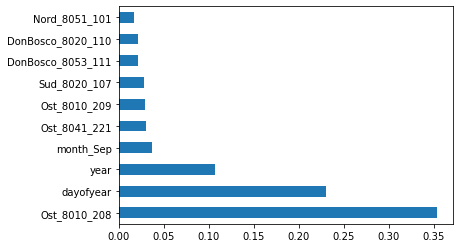

In [34]:
X_train,X_test,Y_train,Y_test = train_test_split(data,Y, random_state = 0)
model = RandomForestRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
r2 = r2_score(Y_test, predictions)      
Y_pred = pd.Series(predictions, index= Y_test.index)

feat_importances = pd.Series(model.feature_importances_, index=data.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [28]:
data = pd.DataFrame.from_dict(dictionary)


In [29]:
data

,DonBosco_8020_119
dt,0.636108
kn,0.637763
lr,0.628994
rf,0.804306


# udajenost i traffic

In [102]:
data = pd.concat([X,df_satelit_new,df_temporal_new],axis=1)


In [103]:
dictionary={}
temp_dict={}
for model_key in models.keys():
        model= models[model_key]
        model = model()
        X_train,X_test,Y_train,Y_test = train_test_split(X,Y, random_state = 0)
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(Y_test, predictions)
        
        temp_dict.update({model_key:r2})
dictionary.update({'DonBosco_8020_119':temp_dict}) 

C:\Users\vpetric\AppData\Local\Temp/ipykernel_16856/3187782529.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)


In [104]:
data = pd.DataFrame.from_dict(dictionary)

In [105]:
data

,DonBosco_8020_119
dt,0.436042
kn,0.486737
lr,0.319779
rf,0.585714


# Normalizirane udaljenosti

In [107]:
dictionary={}
temp_dict={}
for model_key in models.keys():
        model= models[model_key]
        model = model()
        X_train,X_test,Y_train,Y_test = train_test_split(X,Y, random_state = 0)
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(Y_test, predictions)
        
        temp_dict.update({model_key:r2})
dictionary.update({'DonBosco_8020_119':temp_dict}) 

C:\Users\vpetric\AppData\Local\Temp/ipykernel_16856/3187782529.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)


In [108]:
data = pd.DataFrame.from_dict(dictionary)

In [109]:
data

,DonBosco_8020_119
dt,0.417924
kn,0.486737
lr,0.319779
rf,0.579398
